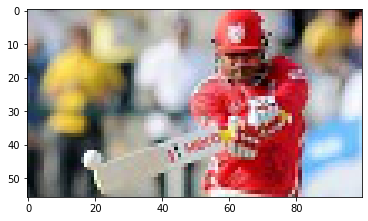

(56, 100, 3)
28 50


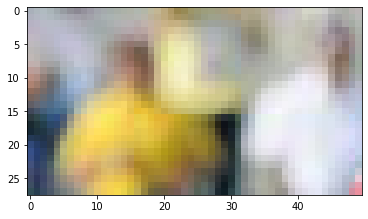

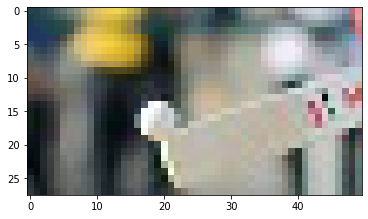

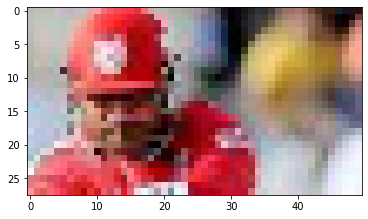

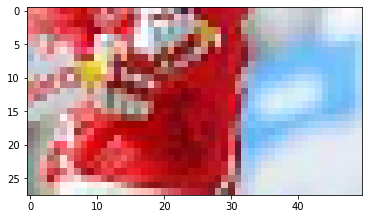

(4,)
(4, 28, 50, 3)
X_train (3, 28, 50, 3)
(28, 50, 3) 3
l2_inputs  (1, 18, 40)
1 18 40
l4_inputs:  720
(1, 4)
4
Epoch: 0 ,Batch: 0 ,loss: 2.0000 one (720, 4) (4,) (1, 720)
(1, 18, 40, 1)
first
(1, 18, 40)
(11, 11, 3)
(1,)
(1, 28, 50, 3)
(1, 18, 40, 1)
i (1, 18, 40, 1) (1, 18, 40)


ValueError: operands could not be broadcast together with shapes (18,40) (18,40,3) 

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image 
import pandas as pd
#import cv2
import os
filter11x11= np.load('filter_weights.npy')
img=Image.open("5.jpg")
kiu=np.asarray(img)
imgplot = plt.imshow(kiu)
plt.show()
print(kiu.shape)
def slicer(img,n_x,n_y):
    #x_strips=math.ceil(n/2)
    #y_strips=n-x_strips
    a,b,c=img.shape
    x_strip_len=int(a/n_y)
    y_strip_len=int(b/n_x)
    print(x_strip_len,y_strip_len)
    res=[]
    for i in range(n_x):
        #print("i",i)
        for j in range(n_y):
            #print("j",j)
            res.append(img[j*x_strip_len:(j+1)*x_strip_len,i*y_strip_len:(i+1)*y_strip_len])
    return res
res=slicer(kiu,2,2)
for i in res:
    #print(i.shape)
    plt.imshow(i,cmap='gray')
    plt.show()
# Creating training data
X =[res[0],res[1],res[2],res[3]]
Y = [0,1,0,0]
x = np.asarray(X, dtype=np.float32)
y = np.asarray(Y, dtype=np.float32)
print(y.shape)
print(x.shape)
def sigmoid(x): 
    return(1/(1+np.exp(-x)))
def conv_forward_pass(inputs, kernel, bias):
    '''Calculate the convolutional foward pass using an activation function 
       Inputs:
       layer_input -> A group of images
       kernel -> a matrix containing the filters and number of filters (kernel_row, kernel_col, kernel_ch, n_filters)
       bias -> Matrix with biases for the convolutional calculation
       
       Output:
       Array containing the output of the images passing through the convolutional layer
       Each output corresponds to a function(x)= activation(z + b)
    '''
    batches = len(inputs)
    conv_outputs =[]
    for batch in range(0,batches):
        layer_input = inputs[batch] #passing a single image through the convolutional layer
        if len(layer_input.shape) == 2: # in the case there input layer has only one channel, e.g black&white picture
            z_row = layer_input.shape[0] - kernel.shape[0] + 1
            z_col = layer_input.shape[1] - kernel.shape[1] + 1
            if len(kernel.shape) == 2: # in the case there is only one filter in the convolutional layer
                z = np.empty((z_row,z_col))
                for i in range(0,z_row):
                    for j in range(0,z_col):
                        x= 0
                        for ik in range(0,kernel.shape[0]):
                            for ij in range(0,kernel.shape[1]):
                                x += layer_input[i+ik,j+ij]*kernel[ik,ij]
                        z[i,j]= x + bias
            else:
                nfilter = kernel.shape[-1]
                z = np.empty((z_row,z_col,nfilter))
                for f in range(0, nfilter):
                    for i in range(0,z_row):
                        for j in range(0,z_col):
                            x= 0
                            for ik in range(0,kernel.shape[0]):
                                for ij in range(0,kernel.shape[1]):
                                    x += layer_input[i+ik,j+ij]*kernel[ik,ij,f]
                            z[i,j,f]= x + bias[f]
        else: # in the case there input layer has more than one channel
            layer_input_ch = layer_input.shape[2]     
            print(layer_input.shape,layer_input_ch)
            z_row = layer_input.shape[0] - kernel.shape[0] + 1
            z_col = layer_input.shape[1] - kernel.shape[1] + 1
            if len(kernel.shape) == 3: # in the case there is only one filter in the convolutional layer
                z = np.empty((z_row,z_col))
                for i in range(0,z_row):
                    for j in range(0,z_col):
                        x= 0
                        for ik in range(0,kernel.shape[0]):
                            for ij in range(0,kernel.shape[1]):
                                for ch in range(0,layer_input_ch):
                                    #print(i+ik,j+ij,ch,ik,ij,ch)
                                    x += layer_input[i+ik,j+ij,ch]*kernel[ik,ij,ch]
                                    #x += bias
                        #print(bias)
                        z[i,j]= x + bias
            else:
                layer_input_ch = layer_input.shape[2]
                nfilter = kernel.shape[-1]
                z = np.empty((z_row,z_col,nfilter))
                a = np.empty(z.shape)
                for f in range(0, nfilter):
                    for i in range(0,z_row):
                        for j in range(0,z_col):
                            for ik in range(0,kernel.shape[0]):
                                for ij in range(0,kernel.shape[1]):
                                    x= 0
                                    for ch in range(0,layer_input_ch):
                                        x += layer_input[i+ik,j+ij,ch]*kernel[ik,ij,ch,f]
                            z[i,j,f]= x + bias[f]
        a = sigmoid(z)
        #a = relu(z)
        conv_outputs.append(a)
    conv_outputs = np.array(conv_outputs)
    return(conv_outputs)
def flatten_foward_pass(input_flatten):
    '''Transform input in a flatten array of one column'''
    batches = len(input_flatten)
    flatten_outputs=[]
    for batch in range(0,batches):
        flatten_outputs.append(np.reshape(input_flatten[batch],-1))    
    flatten_outputs = np.array(flatten_outputs)
    return(flatten_outputs)
def dense_foward_pass(dense_input, n_output_nodes, weights, bias):
    '''Calculate the outputs of a dense layer 
       Inputs:
       dense_input -> result from previous layer
       n_output_nodes -> number of output nodes
       weights -> matrix of weights 
       bias - > Matrix with biases

       Outputs:
       Group of array of nodes considering a activation function of previous nodes * weights + biases 
    '''
    batches = len(dense_input)
    dense_outputs=[]
    for batch in range(0,batches):
        z = np.empty((n_output_nodes))
        for i in range(0,n_output_nodes):
            z[i] = (dense_input[batch] @ weights[:,i]) + bias[i]
        #z = z/len(dense_input[batch])
        a = sigmoid(z)
        #a = relu(z)
        dense_outputs.append(a)    
    return(np.array(dense_outputs))
def stable_softmax(x):
    exps = np.exp(x - np.max(x))
    return(exps / np.sum(exps))

def output_foward_pass(dense_input, n_output_nodes, weights, bias):
    '''Calculate the outputs of a dense layer
       Inputs:
       dense_input -> single result from previous layer
       n_output_nodes -> number of output nodes
       weights -> matrix of weights 
       bias - > Matrix with biases

       Outputs:
       Flatten array of nodes considering a softmax function of previous nodes * weights + biases 
    '''
    batches = len(dense_input)
    dense_outputs=[]
    for batch in range(0,batches):
        z = np.empty((n_output_nodes))
        for i in range(0,z.shape[0]):
            z[i] = dense_input[batch] @ weights[:,i] + bias[i]
        a = stable_softmax(z)
        dense_outputs.append(a)
    dense_outputs = np.array(dense_outputs)
    return(dense_outputs)
def reshape_labels(prediction,labels):
    label_reshape = np.zeros(prediction.shape)
    for i in range(0,len(prediction)):
        label_reshape[i][labels[i]] = 1
    return(label_reshape)

def loss_SSE(prediction, labels):
    loss_SSE = []
    labels_reshape = reshape_labels(prediction, labels)
    for i in range(0,len(prediction)):
        loss_SSE.append(np.sum((prediction[i] - labels_reshape[i])**2))
    return(np.mean(loss_SSE))
def grad_loss(prediction, labels):
    label_reshape = reshape_labels(prediction, labels)
    grad_loss_out = []
    for i in range(0,len(prediction)):
        grad_loss_out.append(2*(prediction[i] - label_reshape[i]))
    return(np.array(grad_loss_out))

def grad_softmax(x):
    '''Compute the gradient of the output layer over each z, Output = softmax(z)
    Input -> Output layer you waht to do the gradient of softmax over
    Outpu -> Matrix of the gradient of each outpu w.r.t each z
    '''
    grad_softmax =[]
    for k in range(0,len(x)):
        jacobian =np.empty((x.shape[-1],x.shape[-1]))
        for i in range(0, jacobian.shape[0]):
            for j in range(0, jacobian.shape[1]):
                if i == j:
                    jacobian[i][j] =  x[k][i] * (1 - x[k][j])
                else:
                    jacobian[i][j] =  x[k][i] * (0 - x[k][j])
        grad_softmax.append(jacobian)            
    return(np.array(grad_softmax))     
def output_backpropagation(prediction, labels, previous_layer_weights, previous_layer_bias, previous_layer_outputs):
    '''Return the gradients of the loss function w.r.t the previous weights, biases, and inputs.
    Inputs:
    Prediction -> Group prediction for the batch
    Labels -> Correct answers for the predictions
    Previous_layer_weights -> Matrix of weights from the previous layer
    Previous_layer_bias -> Array of biases from the previous layer
    Previous_layer_ouput -> Array of the output of previous layer, .e.g, this layer input
    
    Output:
    Gradients for Weights, Biases and previous activation nodes
    '''
    
    # Calculating the Weights Gradients
    
    #Step 1 - Calculate the Gradient of the loss w.r.t the outputs
    grad_loss_outputs = grad_loss(prediction, labels)
    
    #Step 2 - Calculate the Gradient of each output w.r.t each z, where output[i] = softmax(z[i])
    grad_outputs_z = grad_softmax(prediction)
    
    #Step 3 - Calculate the Gradient of each z w.r.t each weight, where z[i] = W[i,j]X[j] + W[i,j+1]X[j+1] ... + W[i,j+n]X[j+n] + b[i]  
    grad_z_weights = previous_layer_outputs
    
    #Step 4 - Calculate the Gradient the loss w.r.t each weight using the chain rule
    w_row = previous_layer_weights.shape[0]
    w_col = previous_layer_weights.shape[1]
    w_ch = len(prediction)
    grad_w = np.empty((w_ch, w_row, w_col))
    for ch in range(0,w_ch):
        for i in range(0, w_row):
            for j in range(0,w_col):
                grad_w[ch,i,j] = (grad_loss_outputs[ch] @ grad_outputs_z[ch][:][j])* grad_z_weights[ch][i]
    
    #Step 5 - Calculate the average of the gradients
    grad_loss_weight = np.empty((w_row,w_col))
    for i in range(0,w_row):
            for j in range(0,w_col):
                grad_loss_weight[i,j] = np.mean(grad_w[:,i,j])
    
    #return(grad_loss_weight)
    
    # Calculating the Bias Gradients
    
    #Step 6 - Calculate the Gradient of each z w.r.t each bias, where z[i] = W[i,j]X[j] + W[i,j+1]X[j+1] ... + W[i,j+n]X[j+n] + b[i]  
    grad_z_bias = 1
    
    #Step 7 - Calculate the Gradient the loss w.r.t each bias using the chain rule
    b_col = len(previous_layer_bias)
    b_ch = len(prediction)
    grad_b = np.empty((b_ch, b_col))
    for ch in range(0,b_ch):
        for j in range(0,b_col):
            grad_b[ch,j] = (grad_loss_outputs[ch] @ grad_outputs_z[ch][j])* grad_z_bias
    
    #Step 8 - Calculate the average of the gradients
    grad_loss_bias = np.empty((b_col))
    for j in range(0,b_col):
        grad_loss_bias[j] = np.mean(grad_b[:,j])
    
    #return(grad_loss_bias)
    
    # Calculating the last layer Activation Node Gradient
    
    #Step 9 - Calculate the Gradient of each z w.r.t each A, where z[i] = W[i,j]A[j] + W[i,j+1]A[j+1] ... + W[i,j+n]A[j+n] + b[i] 
    grad_z_previous_activation = previous_layer_weights
    
    #Step 10 - Calculate the Gradient the loss w.r.t each previous activation layer, using the chain rule
    a_row = previous_layer_outputs.shape[-1]
    a_ch = len(prediction)
    grad_a = np.zeros((a_ch, a_row))
    for ch in range(0,a_ch):
        for i in range(0,a_row):
            for j in range(0, prediction.shape[-1]):
                x = 0
                for sj in range(0, grad_outputs_z.shape[-1]):
                    x += (grad_loss_outputs[ch][j] * grad_outputs_z[ch][j][sj] * grad_z_previous_activation[i][j])
                grad_a[ch,i] = x
       
    return(grad_loss_weight, grad_loss_bias, grad_a)
def inverse_flatten(x, row ,col ,ch):
    '''Return array into matrix of batch,(i,j,ch) dimensions
    Inputs:
    x -> Array of (batch, y) dimension
    (row, col ,ch) -> number of rows, columns and channels the output matrix must have
    
    Output -> Array of dimension (batch, (row,col,ch))
    '''
    inverse_flatten = []
    for batch in range(0,x.shape[0]):
        inverse_flatten.append(x[batch].reshape((row,col,ch)))
    
    return(np.array(inverse_flatten))
def convolutional_input_backpropagation(actual_layer_outputs, previous_layer_kernel_weights, previous_layer_bias, previous_layer_outputs, grad_loss_outputs):
    '''Return the gradients of the loss function w.r.t the previous weights, biases, and inputs.
    Inputs:
    actual_layer_outputs -> Group of the outputs for this layer
    Previous_layer__kernel_weights -> Matrix of weights from the convolutional kernel
    Previous_layer_bias -> Array of biases from the previous layer
    Previous_layer_ouput -> Array of the output of previous layer, .e.g, this layer input
    grad_loss_outputs -> Array of the gradient of the loss function w.r.t. each node of this layer
    
    Output:
    Gradients for Weights, Biases and previous activation nodes
    '''
    # Calculating the Weights Gradients
    
    #Step 1 - Calculate the Gradient of the loss w.r.t the layers node outputs
    '''This step was previously calculated in the backpropagation of the output layer'''
    #grad_loss_outputs = grad_loss_outputs
    
    #Step 2 - Calculate the Gradient of each node w.r.t each z, where output[i] = sigmoid(z[i])
    # Deriviative of sigmoid function
    grad_outputs_z = actual_layer_outputs * (1 - actual_layer_outputs)
    #grad_outputs_z = grad_relu(actual_layer_outputs)
    
    #Step 3 - Calculate the Gradient the loss w.r.t each kernel weight using the chain rule  
    batches = len(actual_layer_outputs)
    n_kernels = previous_layer_kernel_weights.shape[-1]
    k_row = previous_layer_kernel_weights.shape[0]
    k_col = previous_layer_kernel_weights.shape[1]
    
    outputs_row = actual_layer_outputs.shape[1]
    outputs_col = actual_layer_outputs.shape[2]
       
    grad_k = np.empty((batches, k_row, k_col, n_kernels))

    print('i',grad_loss_outputs.shape,grad_outputs_z.shape)

    for batch in range(0,batches):
        for nk in range(0, n_kernels):
            for i in range(0, k_row):
                for j in range(0,k_col):
                    
                    
                    grad_k[batch, i, j] = np.sum((grad_loss_outputs[batch][:,:,nk] * np.transpose(grad_outputs_z[:,:,nk])) *  previous_layer_outputs[batch][i:i+outputs_row,j:j+outputs_col])
                    #grad_k[batch, i, j] = np.sum(np.expand_dims((grad_loss_outputs[batch][:,:,nk] * np.transpose(grad_outputs_z[:,:,nk])), axis=2) *  previous_layer_outputs[batch][i:i+outputs_row,j:j+outputs_col])
                    #(28,50) (1,28) 
                    #grad_k[batch, i, j] = np.sum((grad_loss_outputs[batch][:,:,nk] * grad_outputs_z[:,:,nk]) *  previous_layer_outputs[batch][i:i+outputs_row,j:j+outputs_col])
     
                    #grad_k[batch, i, j] = np.sum((grad_loss_outputs[batch][:,:,nk] * grad_outputs_z[:,:,nk]) *  previous_layer_outputs[batch][i:i+outputs_row,j:j+outputs_col])
    
    #Step 4 - Calculate the average of the gradients
    grad_loss_kernel = np.empty((k_row,k_col, n_kernels))
    for nk in range(0, n_kernels):
        for i in range(0, k_row):
            for j in range(0,k_col):
                grad_loss_kernel[i,j,nk] = np.mean(grad_k[:,i,j,nk])
    
    #return(grad_loss_kernel)
    
    #Step 5 - Calculate the Gradient of each z w.r.t each bias
    grad_z_bias = 1
    #Step 6 - Calculate the Gradient the loss w.r.t each bias using the chain rule
    grad_b = np.empty((batches, n_kernels))
    for batch in range(0,batches):
        for nk in range(0, n_kernels):
            grad_b[batch,nk] = np.sum(grad_loss_outputs[batch][:,:,nk] * grad_outputs_z[batch][:,:,nk])
    
    #Step 7 - Calculate the average of the gradients
    grad_loss_bias = np.empty((n_kernels))
    for nk in range(0, n_kernels):
        grad_loss_bias[nk] = np.mean(grad_b[:,nk])
    
    #return(grad_loss_bias)

    return(grad_loss_kernel, grad_loss_bias)
import math
import sys

def fit_CNN_small(training_features, training_labels, test_features, test_labels, epochs, batch_size, lr):
    '''Fit the CNN architecture to the training data'''
    #================================================================================================================
    # Step 1: initialize weights, kernels, and biases
    #================================================================================================================
    #Layer 1
    #l1_kernel_size = 3
    #l1_kernel_numbers = 3     ##this is kernal channnels and not numbers..hence set it equal to input channels
    l1_kernel = filter11x11
    l1_bias = np.random.randn(1)        ## every kernal has a single bias, hence must be a single value
    
    
     
    output_nodes = 4
    l4_weights =np.random.randn(338,output_nodes) #338 is the input shape from the flatten layer
    l4_bias = np.random.randn(output_nodes)
    
    #================================================================================================================
    # Step 2: divide the number of batches
    #================================================================================================================
    
    number_of_batches = len(training_features)/batch_size
    number_of_batches = math.ceil(number_of_batches)

    #================================================================================================================
    # Step 3: train for each epoch and batch
    #================================================================================================================
    metric=pd.DataFrame(columns=['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    counter = 0
    last_test_acc = 0
    for epoch in range(0, epochs):
        for i in range(0,number_of_batches-1):
            # Forward Pass
            l1_inputs = training_features[i*batch_size:i*batch_size + batch_size] #X_train shape
            l2_inputs = conv_forward_pass(l1_inputs, l1_kernel, l1_bias) #shape (1, 28, 50, 3) for image data 
            #TypeError: Invalid shape (1, 28, 50) for image data
            #plt.imshow(l2_inputs)
            #plt.show()
            print("l2_inputs ",l2_inputs.shape)
            l2_a,l2_b,l2_c=l2_inputs.shape
            print(l2_a,l2_b,l2_c)
            l4_inputs = flatten_foward_pass(l2_inputs)
            print("l4_inputs: ",l4_inputs.size)
            l4_weights =np.random.randn(l4_inputs.shape[-1],output_nodes) #338 is the input shape from the flatten layer
            outputs = output_foward_pass(l4_inputs, output_nodes, l4_weights, l4_bias)
            print(outputs.shape) #(1,2)
            print(outputs.size) #2
            # Calculate Loss
            batch_label = training_labels[i*batch_size:i*batch_size + batch_size] #Epoch: 0 ,Batch: 1 ,loss: 0.0000 
            batch_loss = loss_SSE(outputs, batch_label)
            sys.stdout.write('\rEpoch: %d ,Batch: %d ,loss: %.4f '%(epoch,i,batch_loss))
            sys.stdout.flush()
            # Backpropagation
            grad_l4_weights, grad_l4_bias, grad_l4_inputs = output_backpropagation(outputs, batch_label, l4_weights , l4_bias, l4_inputs)
            print("one",grad_l4_weights.shape,grad_l4_bias.shape, grad_l4_inputs.shape)
            grad_l3_inputs = inverse_flatten(grad_l4_inputs, l2_b,l2_c,l2_a)
            print(grad_l3_inputs.shape) #(1, 28, 50, 1)
            #(28,50) (1,28) 
            print("first")
            print(l2_inputs.shape )
            print( l1_kernel.shape)
            print(l1_bias.shape)
            print(np.array(l1_inputs).shape)
            print(grad_l3_inputs.shape)
            grad_l1_kernel, grad_l1_bias = convolutional_input_backpropagation(l2_inputs, l1_kernel, l1_bias, l1_inputs, grad_l3_inputs)
            
            

            #Updating Kernel, weights and biases
            l1_kernel = l1_kernel - (lr*grad_l1_kernel)
            l1_bias = l1_bias - (lr*grad_l1_bias)

            l4_weights = l4_weights - (lr*grad_l4_weights)
            l4_bias = l4_bias - (lr*grad_l4_bias)


        # Calculate for last batch
        # Forward Pass
        l1_inputs = training_features[(number_of_batches-1)*batch_size:]
        l2_inputs = conv_forward_pass(l1_inputs, l1_kernel, l1_bias)
        l3_inputs = maxpool_forward_pass(l2_inputs, 2, 2)
        l4_inputs = flatten_foward_pass(l3_inputs)
        outputs = output_foward_pass(l4_inputs, output_nodes, l4_weights, l4_bias)

        # Calculate Loss
        batch_label = training_labels[(number_of_batches-1)*batch_size:]
        batch_loss = loss_SSE(outputs, batch_label)
        sys.stdout.write('\rEpoch: %d ,Batch: %d ,loss: %.4f'%(epoch,number_of_batches,batch_loss))
        sys.stdout.flush()

        
        # Backpropagation
        grad_l4_weights, grad_l4_bias, grad_l4_inputs = output_backpropagation(outputs, batch_label, l4_weights , l4_bias, l4_inputs)
        grad_l3_inputs = inverse_flatten(grad_l4_inputs, l2_b,l2_c,l2_a)
        #grad_l2_inputs = inverse_maxpool(grad_l3_inputs, l3_inputs, l2_inputs, 2, 2)
        grad_l1_kernel, grad_l1_bias = convolutional_input_backpropagation(l2_inputs, l1_kernel, l1_bias, l1_inputs, grad_l3_inputs)
        
        #Updating Kernel, weights and biases
        l1_kernel = l1_kernel - (lr*grad_l1_kernel)
        l1_bias = l1_bias - (lr*grad_l1_bias)

        l4_weights = l4_weights - (lr*grad_l4_weights)
        l4_bias = l4_bias - (lr*grad_l4_bias)
    
    #================================================================================================================
    # Step 4: Calculate Epoch train Loss
    #================================================================================================================
        # Calculate for Foward Pass for epoch
        l1_inputs = training_features
        l2_inputs = conv_forward_pass(l1_inputs, l1_kernel, l1_bias)
        l3_inputs = maxpool_forward_pass(l2_inputs, 2, 2)
        #l4_inputs = flatten_foward_pass(l3_inputs)
        outputs = output_foward_pass(l3_inputs, output_nodes, l4_weights, l4_bias)

        # Calculate Epoch train Loss
        batch_label = training_labels
        batch_loss = loss_SSE(outputs, batch_label)
    
    #================================================================================================================
    # Step 5: Calculate Epoch train Accuracy
    #================================================================================================================
    
        outputs_acc = np.zeros(outputs.shape)
        for i in range(0,len(outputs)):
            outputs_acc[i][np.argmax(outputs[i])] = 1.

        labels_reshape = reshape_labels(outputs, batch_label)
        train_acc = np.sum(outputs_acc * labels_reshape)/len(outputs_acc)
               
     #================================================================================================================
    # Step 6: Calculate Epoch test Loss
    #================================================================================================================
        # Calculate for Foward Pass for epoch
        l1_inputs = test_features
        l2_inputs = conv_forward_pass(l1_inputs, l1_kernel, l1_bias)
        #l3_inputs = maxpool_forward_pass(l2_inputs, 2, 2)
        l4_inputs = flatten_foward_pass(l2_inputs)
        outputs_test = output_foward_pass(l4_inputs, output_nodes, l4_weights, l4_bias)

        # Calculate Epoch train Loss
        batch_test_label = test_labels
        batch_test_loss = loss_SSE(outputs_test, batch_label)   

    #================================================================================================================
    # Step 7: Calculate Epoch test Accuracy
    #================================================================================================================
        outputs_test_acc = np.zeros(outputs_test.shape)
        for i in range(0,len(outputs_test)):
            outputs_test_acc[i][np.argmax(outputs_test[i])] = 1.

        labels_reshape = reshape_labels(outputs_test, batch_test_label)
        test_acc = np.sum(outputs_test_acc * labels_reshape)/len(outputs_test_acc)
        
        print('\nEpoch:',epoch,'\tTrain_loss:',batch_loss, '\tTrain_acc:',train_acc,'\tTest_loss:',batch_test_loss, '\tTest_acc:',test_acc)
        metric.loc[counter] = [epoch, batch_loss, train_acc, batch_test_loss, test_acc]
        counter +=1
        
        
    return(l1_kernel, l1_bias, l4_weights, l4_bias, metric)

X_train=res[:3]  ## Input to train will be first three slices of the same image
Y_train=[1,0,0]   ## Assuming ROI is the first index
X_test=res[3]    ## fourth slice as test input
Y_test=[0]        ## since last slice is not ROI hence label=0
print("X_train",np.array(X_train).shape)
l1_kernel, l1_bias, l4_weights, l4_bias, metric = fit_CNN_small(X_train, Y_train, X_test, Y_test, 1, 1, 1e-02)
